<a href="https://colab.research.google.com/github/Santhose-DOC/Ex1-AAI/blob/main/experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy pgmpy matplotlib


In [2]:
!pip install networkx==2.8.8


Step 1: Import libraries

In [3]:
import pandas as pd
import numpy as np

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import networkx as nx
import matplotlib.pyplot as plt

Step 2: Load dataset

In [4]:
df = pd.read_csv("weatherAUSnew.csv")   # change path if needed


Step 3: Data preprocessing

In [5]:
# Remove rows where target is missing
df = df[pd.isnull(df['RainTomorrow']) == False]

# Drop Date column
df = df.drop(columns='Date')

# Fill missing numeric values with mean
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())


Step 4: Discretization (Categorical variables)

In [6]:
df['WindGustSpeedCat'] = df['WindGustSpeed'].apply(
    lambda x: '0.<=40' if x <= 40 else
              '1.40-50' if 40 < x <= 50 else
              '2.>50'
)

df['Humidity9amCat'] = df['Humidity9am'].apply(
    lambda x: '1.>60' if x > 60 else '0.<=60'
)

df['Humidity3pmCat'] = df['Humidity3pm'].apply(
    lambda x: '1.>60' if x > 60 else '0.<=60'
)


Step 5: Prepare data for Bayesian Network

In [7]:
bn_df = df[
    ['WindGustSpeedCat', 'Humidity9amCat', 'Humidity3pmCat', 'RainTomorrow']
].copy()

# Convert all columns to categorical (string)
for col in bn_df.columns:
    bn_df[col] = bn_df[col].astype(str)

print(bn_df.head())

  WindGustSpeedCat Humidity9amCat Humidity3pmCat RainTomorrow
0          1.40-50          1.>60         0.<=60           No
1          1.40-50         0.<=60         0.<=60           No
2          1.40-50         0.<=60         0.<=60           No
3           0.<=40         0.<=60         0.<=60           No
4          1.40-50          1.>60         0.<=60           No


Step 6: Define Bayesian Network structure

In [8]:
model = DiscreteBayesianNetwork([
    ('Humidity9amCat', 'Humidity3pmCat'),
    ('Humidity3pmCat', 'RainTomorrow'),
    ('WindGustSpeedCat', 'RainTomorrow')
])

Step 7: Train Bayesian Network (learn CPTs)

In [9]:
model.fit(bn_df, estimator=MaximumLikelihoodEstimator)


Display Conditional Probability Tables

In [10]:
for cpd in model.get_cpds():
    print(cpd)
    print("-" * 60)


+------------------------+----------+
| Humidity9amCat(0.<=60) | 0.306583 |
+------------------------+----------+
| Humidity9amCat(1.>60)  | 0.693417 |
+------------------------+----------+
------------------------------------------------------------
+------------------------+------------------------+-----------------------+
| Humidity9amCat         | Humidity9amCat(0.<=60) | Humidity9amCat(1.>60) |
+------------------------+------------------------+-----------------------+
| Humidity3pmCat(0.<=60) | 0.928269945405331      | 0.5576020040771205    |
+------------------------+------------------------+-----------------------+
| Humidity3pmCat(1.>60)  | 0.071730054594669      | 0.44239799592287954   |
+------------------------+------------------------+-----------------------+
------------------------------------------------------------
+-------------------+-----+-------------------------+
| Humidity3pmCat    | ... | Humidity3pmCat(1.>60)   |
+-------------------+-----+---------------------

BAYESIAN NETWORK DIAGRAM


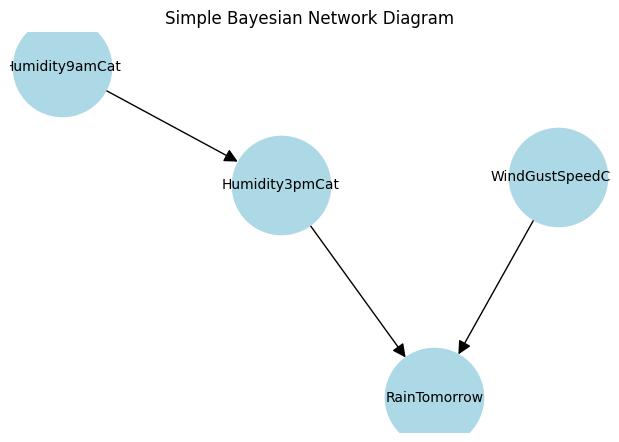

In [43]:
# Create a simple directed graph
G = nx.DiGraph()

# Add edges (Bayesian Network structure)
G.add_edge("Humidity9amCat", "Humidity3pmCat")
G.add_edge("Humidity3pmCat", "RainTomorrow")
G.add_edge("WindGustSpeedCat", "RainTomorrow")

# Draw the graph
plt.figure(figsize=(6, 4))
nx.draw(
    G,
    with_labels=True,
    node_size=5000,
    node_color="lightblue",
    font_size=10,
    arrowsize=20
)

plt.title("Simple Bayesian Network Diagram")
plt.show()

INFERENCE


In [44]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)

result = inference.query(
    variables=['RainTomorrow'],
    evidence={
        'Humidity3pmCat': '1.>60',
        'WindGustSpeedCat': '2.>50'
    }
)

print(result)

+-------------------+---------------------+
| RainTomorrow      |   phi(RainTomorrow) |
+===================+=====================+
| RainTomorrow(No)  |              0.3218 |
+-------------------+---------------------+
| RainTomorrow(Yes) |              0.6782 |
+-------------------+---------------------+
